In [64]:
import numpy as np
import time
import random

In [4]:
B = 18000
N = 100
n_iter = 10000
vec = np.zeros(shape=(B, N))

def roll_vec(vec):
    vec = np.roll(vec, -1, axis=0)
    vec[-1] = 0
    return vec

def vstack_vec(vec):
    return np.vstack((vec[1:], np.zeros((1, N))))

start = time.time()
for i in range(n_iter):
    vec = roll_vec(vec)
end = time.time()
print(f"roll_vec: {(end - start)/n_iter*1e6} microseconds")

start = time.time()
for i in range(n_iter):
    vec = vstack_vec(vec)
end = time.time()
print(f"vstack_vec: {(end - start)/n_iter*1e6} microseconds")

# vec = np.roll(vec, -1, axis=0)
# vec[-1] = 0

roll_vec: 4847.457385063171 microseconds
vstack_vec: 4511.596465110779 microseconds


In [136]:
class CircularBuffer:
    """
    A fast circular buffer implementation using numpy arrays.
    Optimized version that minimizes array operations and copies.

    Parameters
    ----------
    size : int or tuple
        Size of the buffer. If tuple, creates a 2D array of shape size.
        For 1D buffer, pass an integer size.

    Attributes
    ----------
    buffer : ndarray
        The underlying numpy array storing the data
    length : int
        Length of the first dimension of the buffer
    size : int or tuple
        Original size parameter used to create the buffer
    index : int
        Current position in the circular buffer

    Methods
    -------
    __call__()
        Returns the buffer contents in chronological order
    __getitem__(index)
        Access buffer elements relative to current position
    __setitem__(index, value) 
        Set buffer elements relative to current position
    roll(shift=-1)
        Rotate buffer position by shift steps
    step(shift=-1)
        Rotate buffer and zero the new position
    """
    def __init__(self, size):
        self.buffer = np.zeros(size, dtype=np.int16)
        self.length = size[0] if isinstance(size, tuple) else size
        self.size = size
        self.index = 0
        
    def __call__(self):
        if self.index == self.length - 1:
            return self.buffer
        result = np.empty_like(self.buffer)
        np.concatenate((self.buffer[self.index+1:], self.buffer[:self.index+1]), out=result)
        return result
    
    def __getitem__(self, index):
        if isinstance(index, tuple):
            if isinstance(index[0], slice):
                start = 0 if index[0].start is None else index[0].start
                stop = self.length if index[0].stop is None else index[0].stop
                step = 1 if index[0].step is None else index[0].step
                idx = np.mod(np.arange(start, stop, step) + self.index + 1, self.length)
                return self.buffer[idx, index[1]]
            else:
                idx = (self.index + index[0] + 1) % self.length
                return self.buffer[idx, index[1]]
            
        return self.buffer[(self.index + index + 1) % self.length]

    def __setitem__(self, index, value):
        if isinstance(index, tuple):
            self.buffer[(self.index + index[0] + 1) % self.length, index[1]] = value
        else:
            self.buffer[(self.index + index + 1) % self.length] = value
    
    def __len__(self):
        return self.length
    
    def __repr__(self):
        return f"CircularBuffer(size={self.size})"

    def roll(self, shift=-1):
        self.index = (self.index - shift) % self.length
    
    def step(self, shift=-1):
        self.roll(shift)
        self.buffer[self.index] = 0


class FastBinner:
    """
    A fast binning implementation for neural spike data using circular buffers.
    
    This class efficiently bins neural spikes into time windows, supporting both
    single-unit and multi-unit configurations. It uses an optimized CircularBuffer
    implementation for minimal memory operations.

    Parameters
    ----------
    bin_size : float
        Size of each time bin in seconds
    n_id : int
        Number of neural units to track
    n_bin : int 
        Number of time bins to maintain in the buffer
    i_id : int, optional
        If specified, only track spikes from this unit ID
    sampling_rate : int, optional
        Recording sampling rate in Hz, defaults to 25000

    Attributes
    ----------
    count_vec : CircularBuffer
        Circular buffer storing spike counts, shape (n_bin, n_id) or (n_bin,)
    time_to_bin : float
        Conversion factor from timestamp to bin number
    last_bin : int
        Index of the last updated time bin
    """
    def __init__(self, bin_size, n_id, n_bin, id=None, sampling_rate=25000):
        self.bin_size = bin_size
        self.N = n_id
        self.B = n_bin
        self.id = int(id) if id is not None else None
        buffer_size = (self.B, self.N) if self.id is None else self.B
        self.count_vec = CircularBuffer(size=buffer_size)
        self.time_to_bin = 1.0 / (self.bin_size * sampling_rate)
        self.last_bin = 0
    
    def input(self, bmi_output):
        """
        Process an input spike and update the appropriate bin count.

        Parameters
        ----------
        bmi_output : object
            Object containing spike timestamp and unit ID information
        """
        current_bin = int(bmi_output.timestamp * self.time_to_bin)
        spk_id = int(bmi_output.spk_id)
        
        if current_bin != self.last_bin:
            self.count_vec.step()
            self.last_bin = current_bin
            
        if self.id is None:
            self.count_vec[-1, spk_id] += 1
        elif self.id == spk_id:
            self.count_vec[-1] += 1
    
    def output(self):
        """
        Get the current state of all bins.

        Returns
        -------
        ndarray
            Array of spike counts across all bins
        """
        return self.count_vec()

class BMIoutput:
    def __init__(self, n_units=10, fs=25000):
        self.n_units = n_units
        self.timestamp = 0
        self.fs = fs

    def __call__(self):
        cur_min = int(self.timestamp/self.fs/60) + 5 # from 5 Hz to 35 Hz
        self.timestamp += int(random.gammavariate(1/cur_min, 1)*self.fs)
        self.spk_id = 1
        return self

B = 180
N = 10
n_iter = 1000000
buf = CircularBuffer(size=B)

start = time.time()
for i in range(n_iter):
    buf.step()
end = time.time()
print(f"step: {(end - start)/n_iter*1e9} nanoseconds")

step: 432.2929382324219 nanoseconds


In [141]:
binner = FastBinner(bin_size=10, n_id=N+1, n_bin=B, id=1)
bmi = BMIoutput(n_units=N)

start = time.time()
for i in range(n_iter):
    bmi_output = bmi()
    if bmi_output.timestamp > 25000*1800:
        break
    binner.input(bmi_output)
end = time.time()
print(f"input: {(end - start)/i*1e6} microseconds")


input: 6.129915681679813 microseconds


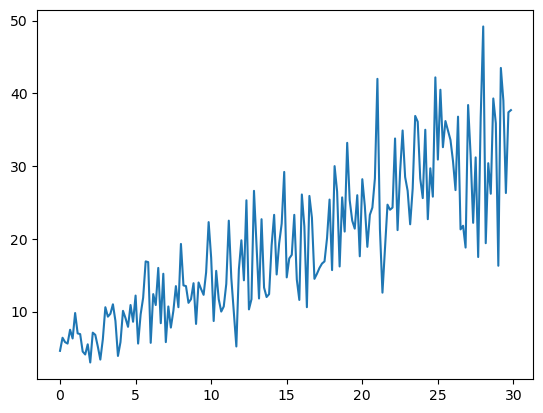

In [142]:
import matplotlib.pyplot as plt
t = np.arange(0, 1800, 10) / 60
plt.plot(t, binner.output() / 10)

In [107]:
buf[-1] = np.random.randint(0, 10, size=(N,))
buf.step()
buf[-1] = np.random.randint(0, 100, size=(N,))
buf.step()
buf[-1] = np.random.randint(0, 1000, size=(N,))

ValueError: setting an array element with a sequence.